# Expanding beam in a drift - zero current

The following notebook documents the free expansion of a beam in a drift, simulated with Synergia. A KV distribution is generated and traverses a 4m drift. The RMS beam properties are calculated and compare with theory.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import tables
from mpi4py import MPI

sys.path.append('/home/vagrant/jupyter/beamsim/synergia/') 

In [3]:
from base_diagnostics import utils
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from base_diagnostics import lfplot
from base_diagnostics import latticework
from base_diagnostics import basic_calcs
from base_diagnostics import pltbunch
from base_diagnostics import elliptic_sp
from base_diagnostics import singleparticle
from base_diagnostics import options
from elliptic import EllipticBeam6D
import synergia
import synergia_workflow

In [4]:
lattices = {}
lattice_dir = '/home/vagrant/jupyter/beamsim/synergia/lattices/Iota6-6/'
lattices['t3_1IO'] = lattice_dir + "lattice_1IO_nll_center.madx"

lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices['t3_1IO'])

reference_particle = lattice.get_reference_particle()
beta = reference_particle.get_beta()

## Construct lattice

In [5]:
#load options
from iota_66_1IO_nll_space_charge_options import opts

comm = synergia.utils.Commxx()
myrank = comm.get_rank()
mpisize = comm.get_size()
verbose = opts.verbosity>0

In [6]:
#Construct the lattice
ol = 0.02 #2cm drift
steps_per_element = 2 #2 steps per drift
o = synergia.lattice.Lattice_element("drift", "o")
o.set_double_attribute("l", ol)

lattice = synergia.lattice.Lattice("test", synergia.lattice.Mad8_adaptor_map())
# Add copies of the lattice elements to the fodo lattice
lattice.append(o)

# Define reference particle to be a proton at 2.5 MeV
total_energy = synergia.foundation.pconstants.proton_mass + 2.5e-3 # 2.5 MeV KE
four_momentum = synergia.foundation.Four_momentum(synergia.foundation.pconstants.proton_mass, total_energy)
reference_particle = synergia.foundation.Reference_particle(synergia.foundation.pconstants.proton_charge,
                                        four_momentum)
opts.gamma = reference_particle.get_gamma()
opts.beta = reference_particle.get_beta()
lattice.set_reference_particle(reference_particle)

#force these for test run
#gridx = 64
#gridy = 64
#gridz = 1
#grid = [gridx, gridy, gridz]
#opts.gridx = gridx
#opts.gridy = gridy
#opts.gridz = gridz

n_ppc = 100 #n_ppc particles per transverse cell
#n_macro = n_ppc*opts.gridx*opts.gridy
n_macro = 50000
opts.macro_particles = n_macro
outputdir = 'ZC_drift_test'
opts.output_dir = outputdir
opts.relpath = opts.output_dir
workflow.make_path(outputdir)

#opts.comm_divide = 4
#if opts.comm_divide:
#    sc_comm = synergia.utils.Commxx_divider(opts.comm_divide, False)
#else:
#    sc_comm = synergia.utils.Commxx(True)

#sc_comm = synergia.utils.Commxx(True)
#if opts.solver == "2dopen-hockney":
#    coll_operator = synergia.collective.Space_charge_2d_open_hockney(sc_comm, grid)

#

#use a dummy operator
coll_operator = synergia.simulation.Dummy_collective_operator("dummy")


map_order = 1
nsteps_per_element = 2
opts.steps_per_element = nsteps_per_element
stepper = synergia.simulation.Split_operator_stepper_elements(lattice, map_order,coll_operator, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

opts.lattice = lattice
opts.lattice_simulator = lattice_simulator

## Construct the bunch

We can use the StandardBeam6D module to construct a KV beam for a desired emittance.

In [24]:
from base_diagnostics import StandardBeam6D
current = 14.e-3 #mA of current 
rp_perlength = current/(beta*scipy.constants.c*scipy.constants.e)
bunch_length = 2*1.e-3 #effective bunch length 2 mm
real_particles = rp_perlength*bunch_length

opts.emit_n = 0.3*1.e-6 #We want 0.3 mm-mrad normalized emittance
opts.emits = [basic_calcs.calc_geometric_emittance(opts.emit_n,opts.beta,opts.gamma)]
dpop = 0.0
opts.real_particles = rp_perlength*bunch_length
opts.betae = 1.0
opts.alphae = 0.0

opts.macro_particles = n_macro
particles = StandardBeam6D.toyKVBeam6D(opts)
bunch = particles[0]
bunch[:,4] = bunch_length*(np.random.random(len(bunch)) -0.5) #center at 0
bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch)) #set dp/p

#Fix the weirdness with particle ID 4
bunch[4] = bunch[100]
bunch[4,6] = 4.0

np.savetxt('myKVBunch.txt',bunch)         #write the bunch to a text file

In [8]:
opts.emits

[4.106875547595129e-06]

Loading Synergia particles from txt file:  myKVBunch.txt
Read  50000  particles


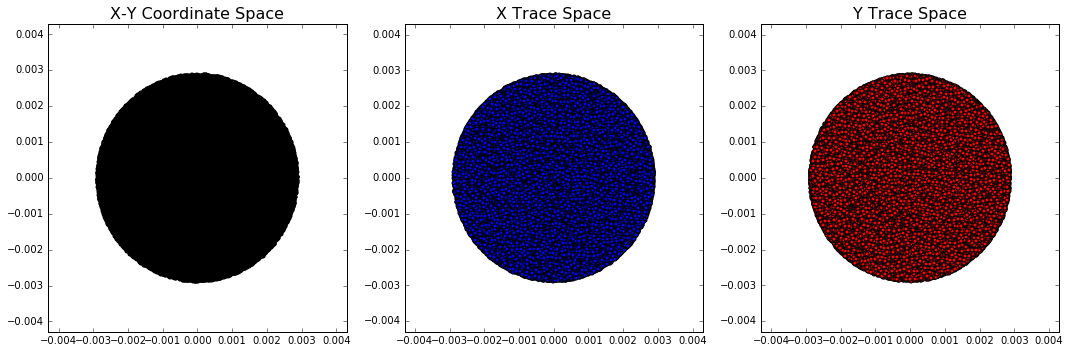

In [9]:
particles_file = 'myKVBunch.txt'
bucket_length = 1. #
comm = synergia.utils.Commxx(True) #define a communicator
myBunch = read_bunch.read_bunch(particles_file, reference_particle, opts.real_particles, bucket_length, comm)
pltbunch.plot_bunch(myBunch)

In [10]:
particles_file = 'myKVBunch.txt'
bucket_length = 1. #
comm = synergia.utils.Commxx(True) #define a communicator
origBunch = read_bunch.read_bunch(particles_file, reference_particle, opts.real_particles, bucket_length, comm)

hArray, iArray = elliptic_sp.calc_bunch_H(origBunch,opts,elliptic=False)
emit_orig = hArray[0]
print hArray[:10]

Loading Synergia particles from txt file:  myKVBunch.txt
Read  50000  particles
[  4.10687555e-06   4.10687555e-06   4.10687555e-06   4.10687555e-06
   4.10687555e-06   4.10687555e-06   4.10687555e-06   4.10687555e-06
   4.10687555e-06   4.10687555e-06]


In [11]:
basic_calcs.calc_properties(origBunch,reference_particle)
gemitx = basic_calcs.get_emittance('x',origBunch)

rms envelope x: 1.43213148683 mm
rms envelope y: 1.43343829791 mm
maximum x value is : 2.86330600541 mm
maximum y value is : 2.85883816893 mm
rms beta x: 0.999921909931
rms beta y: 0.999528539606
geometric emittance x: 2.05116077086 mm-mrad
geometric emittance y: 2.05571454191 mm-mrad
normalized emittance x: 0.14983366896 mm-mrad
normalized emittance y: 0.150166313886 mm-mrad
mean of xp^2 : 2.05132095865e-06
mean of yp^2 : 2.05668418705e-06
total geometric emittance x: 8.1991615537 mm-mrad
total geometric emittance y: 8.17681071853 mm-mrad


## Run the simulation

In [12]:
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#particle diagnostics - PER TURN
opts.turnsPerDiag = 1
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag, opts.turnsPerDiag)

In [13]:
#opts.turns = int(4./lattice.get_length()) #200 turns
opts.turns = 200
opts.checkpointperiod = 50
opts.maxturns = opts.turns+1

propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)

workflow.cleanup(opts.output_dir)

## Diagnostics

#### Quick check of z trace space

In [14]:
##Initial emittance
opts.relpath = opts.output_dir
files = elliptic_sp.get_file_list(opts)
twiss = elliptic_sp.get_toy_twiss(opts)
lost = elliptic_sp.get_lost_particle_list(opts)

if len(lost) > 0:
    #we have lost particles
    opts.lost = lost #store these in opts.lost
    lost = True #make lost a simple flag

#after turn1
outfile = files[1]
if lost:
    header, particles, lost_particles = elliptic_sp.get_particles(outfile, lost,opts.lost)
else:
    header, particles = elliptic_sp.get_particles(outfile, lost)

comm = synergia.utils.Commxx(True)
bucket_length = 10.
turn1Bunch = synergia.bunch.Bunch(
        reference_particle,
        particles.shape[0], opts.real_particles, comm,
        bucket_length)

local_num = turn1Bunch.get_local_num()
local_particles = turn1Bunch.get_local_particles()
local_particles[:,:]= particles[:,:]

#last bunch
outfile = files[-1]
if lost:
    header, particles, lost_particles = elliptic_sp.get_particles(outfile, lost,opts.lost)
else:
    header, particles = elliptic_sp.get_particles(outfile, lost)

comm = synergia.utils.Commxx(True)
bucket_length = 10.
endBunch = synergia.bunch.Bunch(
        reference_particle,
        particles.shape[0], opts.real_particles, comm,
        bucket_length)

local_num = endBunch.get_local_num()
local_particles = endBunch.get_local_particles()
local_particles[:,:]= particles[:,:]

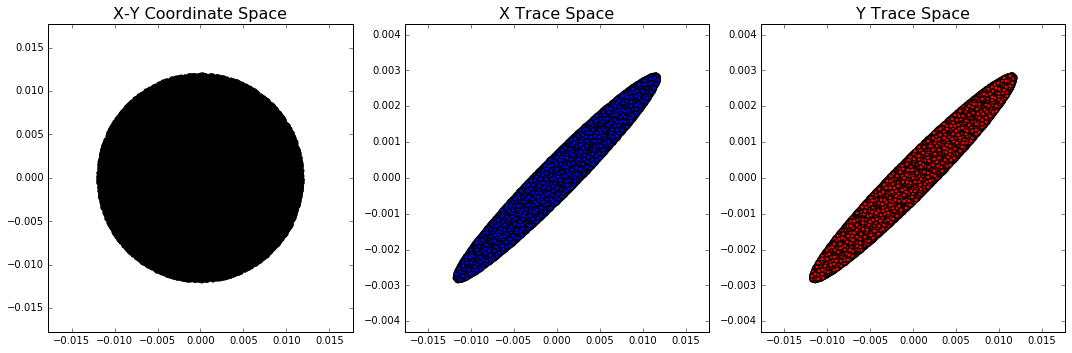

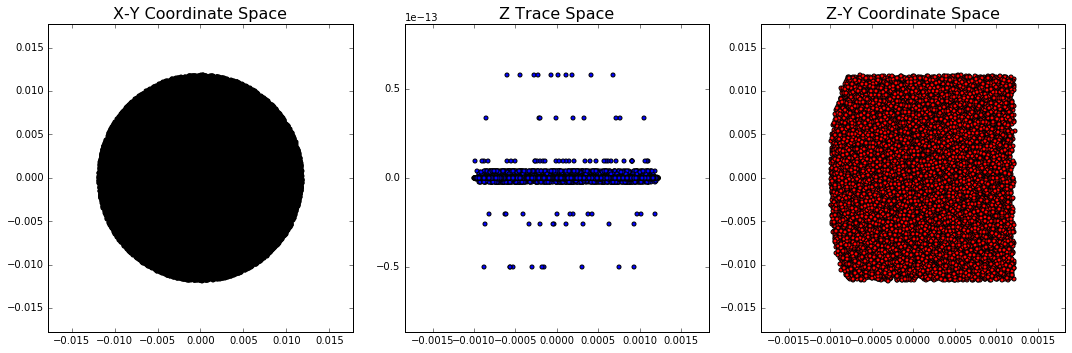

In [15]:
pltbunch.plot_bunch(endBunch)
pltbunch.plot_long(endBunch)

In [16]:
from base_diagnostics import diagplot2

opts.inputfile = opts.output_dir + '/basic.h5'
opts.plots = ['x_std', 'y_std', 'x_mean','y_mean']
plotVals = diagplot2.getPlotVals(opts.inputfile, opts.plots)

#define specific value arrays
xmaster = plotVals['s']
xstd = plotVals['x_std']
ystd = plotVals['y_std']

#### First plot the envelope via the basic.h5 statistics

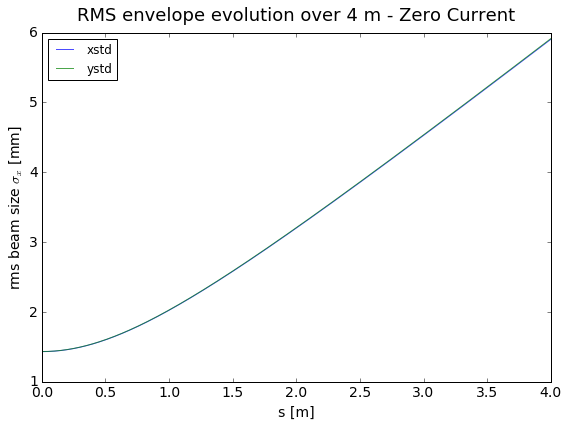

In [17]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(xmaster,xstd*1.e3,'b-', alpha=0.7, label='xstd') #plot x
ax.plot(xmaster,ystd*1.e3,'g-', alpha=0.7, label='ystd') #plot y
#ax.plot(sval_0,xstd_100*1.e3,'g-',alpha=0.7, label='Turn 100') #plot the 1st turn
axtitle = "RMS envelope evolution over 4 m - Zero Current"
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,4.0])
ax.legend(loc=2)
sv_title = 'ZC_test_envelope.pdf'
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

#### Now plot using particle data

In [18]:
opts.relpath = opts.output_dir
files = elliptic_sp.get_file_list(opts)
twiss = elliptic_sp.get_toy_twiss(opts)
lost = elliptic_sp.get_lost_particle_list(opts)

if len(lost) > 0:
    #we have lost particles
    opts.lost = lost #store these in opts.lost
    lost = True #make lost a simple flag


xrms_vals = []
    
for outfile in files:

    if lost:
        header, particles, lost_particles = elliptic_sp.get_particles(outfile, lost,opts.lost)
    else:
        header, particles = elliptic_sp.get_particles(outfile, lost)
    
    xrms = np.std(particles[:,0])
    
    xrms_vals.append(xrms)

zvals = (4/200)*np.asarray(list(range(201))) #construct s value parameters
xrms_vals = np.asarray(xrms_vals)

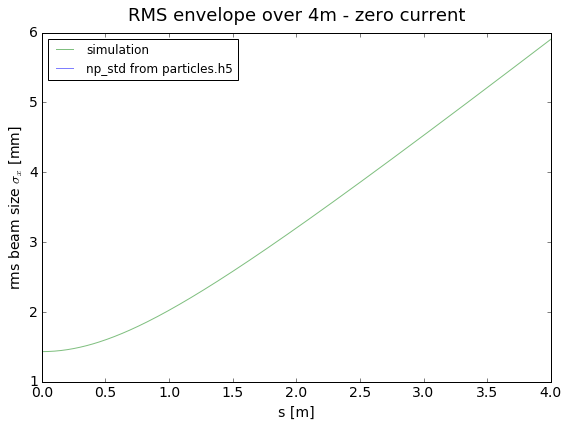

In [19]:
#Compare the two
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(xmaster,xstd*1.e3,'g-',alpha=0.5, label = 'simulation') #plot x
#ax.plot([p[0] for p in points], [p[1]*1.e3 for p in points], label = 'theory-14 mA')
ax.plot(zvals,xrms_vals*1.e3, 'b',alpha=0.5, label = 'np_std from particles.h5')
#ax.plot([p[0] for p in points2], [p[1]*1.e3 for p in points2],'k', label = 'theory - zero mA')
axtitle = "RMS envelope over 4m - zero current"
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,4.0])
ax.legend(loc = 2)
sv_title = 'ZC_test_envelope_compare.pdf'
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

They are in agreement! This is good.

#### Quick calculation of zero current expansion

In [20]:
def calc_perveance(I,ref,cn=0):
    '''Calculate the perveance for a proton beam of a given current and particle energy.
    
    Arguments
        - I - current in A
        - ref - the reference particle for extracting beta and gamma
        
        - (optional) charge neutralization factor - default 0
    '''
    
    I0 = 3.13e7 #characteristic current
    
    beta = ref.get_beta()
    gamma = ref.get_gamma()
    
    return (I/I0)*(2/beta**3)*(1/gamma**3)

def calc_characteristic_current():
    '''Return characteristics current for proton beam'''
    return 4*np.pi*scipy.constants.epsilon_0*scipy.constants.m_p*(scipy.constants.c**3)/scipy.constants.e

In [21]:
#Introduce numerical integrators
import math
from __future__ import division

#we are incrementing (stepping through z) I suppose
N = 400 #number of steps (e.g. 1 cm steps)
z0 = 0.0 #start
zf = 4.0 #end
ss = (zf-z0)/N #step size

zpoints = np.linspace(0.0, 4.0, num=N) #define z values
rpoints = [] #empty array for r values


#initial conditions
#current= 0.0005 
#current = 0.014/(400.)
current = 0
Kp = calc_perveance(current, reference_particle)
rprime0 = (xstd[1]-xstd[0])/(xmaster[1]-xmaster[0]) #need to seed with a nonzero initial rprime
r0 = xstd[0] #initial envelope value
#emit = hA[0,1] #emittance in m-rad -> geometric not normalized
emit = gemitx  #rms geometric emittance

#function here, which is a function of r and z
def rprime(K,emit,r0,rp0,rm):
    '''Returns the slope of the beam envelope (dr/dz) 
    for a given value of emittance,rm, K, and initial conditions'''
    
    first = rp0**2 #first term
    second = (emit**2)*((1./r0**2)-(1./rm**2)) #second term
    third = 2*K* np.log(rm/r0)
    
    return np.sqrt(first + second + third)


#x is r
#z is t (what we step up)
#f is our function describing the relationship between r and z
f = lambda r: rprime(Kp,emit,r0,rprime0,r)

#2nd Order RK - Ralston Method
def Ralston(r,z,h,f):
    k1 = h*f(r)
    return 0.25*k1 + 0.75*h*f(r+(2/3)*k1)

#4th Order Runge-Kutta
def RungeKutta4(r,z,h,f):
    k1 = f(r)
    k2 = f(r + (h/2)*k1)
    k3 = f(r + (h/2)*k2)
    k4 = f(r + h*k3)
    return h/6*(k1 + 2*k2 +2*k3 + k4)
 

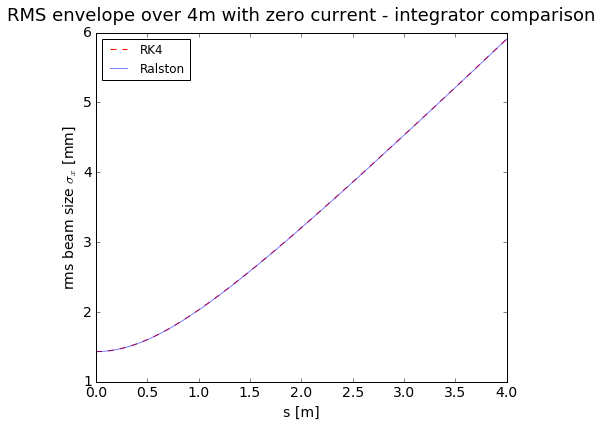

In [22]:
r,z,dz = r0,0,ss
points = []
while z < zf:
    points.append((z,r))
    z, r = z+dz, r + Ralston(r,z,dz,f) #incremement
    
r,z,dz = r0,0,ss
pointsRK4 = []
while z < zf:
    pointsRK4.append((z,r))
    z, r = z+dz, r + RungeKutta4(r,z,dz,f) #incremement


#Compare the integrators
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot([p[0] for p in pointsRK4], [p[1]*1.e3 for p in pointsRK4],'r--',alpha=1, label = 'RK4') #plot x
#ax.plot([p[0] for p in points], [p[1]*1.e3 for p in points], label = 'theory-14 mA')
#ax.plot(zvals,xrms_vals*1.e3, 'b',alpha=0.5, label = 'np_std from particles.h5')
ax.plot([p[0] for p in points], [p[1]*1.e3 for p in points],'b-',alpha=0.5, label = 'Ralston')
axtitle = "RMS envelope over 4m with zero current - integrator comparison"
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,4.0])
ax.legend(loc = 2)
sv_title = 'ZC_envelope_integrator_compare.pdf'
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

## Compare Theoretical Expansion to Simulated Expansion

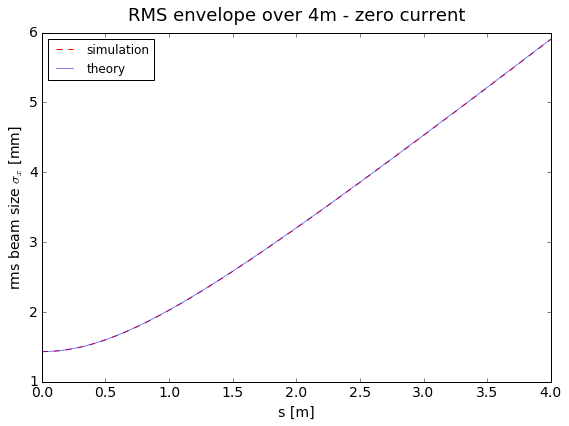

In [23]:
#Compare the two
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(xmaster,xstd*1.e3,'r--',alpha=1, label = 'simulation') #plot x
#ax.plot([p[0] for p in points], [p[1]*1.e3 for p in points], label = 'theory-14 mA')
#ax.plot(zvals,xrms_vals*1.e3, 'b',alpha=0.5, label = 'np_std from particles.h5')
ax.plot([p[0] for p in points], [p[1]*1.e3 for p in points],'b-',alpha=0.5, label = 'theory')
axtitle = "RMS envelope over 4m - zero current"
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,4.0])
ax.legend(loc = 2)
sv_title = 'ZC_test_envelope_compare.pdf'
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

In [25]:
np.random.random?


We see excellent agreement between the predicted and simulated expansion in the zero current limit.